# admirals - stlr features
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Feb 25, 2022

## Hypothesis
The goal of this notebook is to compare the results of the model with the model using standard StellarAlgo features with the engineered retention model features.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '34.206.73.189'  
DATABASE = 'datascience' 
USERNAME = 'nrad' 
PASSWORD = '83F25619-D272-4660-98A2-93AF5CC18D59'#getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [3]:
lkupclientid = 16 # admirals
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrAHL].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(11068, 54)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11068 entries, 0 to 11067
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   lkupClientId            11068 non-null  int64  
 1   dimCustomerMasterId     11068 non-null  int64  
 2   customerNumber          11068 non-null  object 
 3   year                    11068 non-null  int64  
 4   productGrouping         11068 non-null  object 
 5   totalSpent              11068 non-null  float64
 6   recentDate              11068 non-null  object 
 7   attendancePercent       11068 non-null  float64
 8   renewedBeforeDays       11068 non-null  int64  
 9   isBuyer                 11068 non-null  object 
 10  source_tenure           11068 non-null  int64  
 11  tenure                  11068 non-null  int64  
 12  distToVenue             11068 non-null  float64
 13  totalGames              11068 non-null  int64  
 14  recency                 11068 non-null

### We should specify the features used in our model:

In [5]:
# choose the features for the stellar base retention model
features = [
    "dimCustomerMasterId",
                "attendancePercent",
                "distToVenue",
                "missed_games_1",
                "missed_games_2",
                "missed_games_over_2",
                "totalSpent",
                "recency",
                "source_tenure",
                "renewedBeforeDays",
                "isNextYear_Buyer",
                "productGrouping",
                "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (8034, 13)
Unseen Data For Predictions: (1418, 13)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [6]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
    "attendancePercent",
                "distToVenue",
                "missed_games_1",
                "missed_games_2",
                "missed_games_over_2",
                "totalSpent",
                "recency",
                "source_tenure",
                "renewedBeforeDays"
    ]
);

In [7]:
model_matrix = compare_models(
    fold=10,
    include=["lr", "xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.7263,0.7954,0.6321,0.6946,0.6614,0.4326,0.4343,0.7860
lr,Logistic Regression,0.6914,0.7325,0.5201,0.6768,0.5876,0.3480,0.3560,0.5150


In [8]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7145,0.7746,0.5897,0.6923,0.6369,0.4041,0.4077
1,0.7145,0.8053,0.6345,0.6740,0.6536,0.4112,0.4117
2,0.7262,0.8033,0.6228,0.6977,0.6581,0.4310,0.4330
3,0.7291,0.7917,0.6609,0.6871,0.6737,0.4423,0.4426
4,0.7394,0.8033,0.6886,0.6934,0.6910,0.4657,0.4657
5,0.7335,0.7940,0.6194,0.7131,0.6630,0.4444,0.4474
6,0.7218,0.7968,0.6090,0.6957,0.6494,0.4205,0.4231
7,0.7496,0.8103,0.6505,0.7287,0.6874,0.4797,0.4819
8,0.7111,0.7789,0.5952,0.6825,0.6359,0.3983,0.4009
9,0.7229,0.7964,0.6505,0.6812,0.6655,0.4292,0.4295


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

### Let's load in our 2021 season data and get retention scores using the model:

In [9]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference.shape

(1616, 54)

In [10]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupClientId,dimCustomerMasterId,customerNumber,year,productGrouping,totalSpent,recentDate,attendancePercent,renewedBeforeDays,isBuyer,...,education,urbanicity,credits_after_refund,is_Lockdown,NumberofGamesPerSeason,CNTPostponedGames,isNextYear_Buyer,Label,Score_0,Score_1
9452,16,1376755,1706812,2021,Flex Plan,290.25,2021-10-16,1.000000,3,TRUE,...,0,0,0.0,1,53,0,0,0,0.7806,0.2194
9453,16,1376809,105700,2021,Full Season,1338.00,2022-02-05,0.948718,571,TRUE,...,0,0,0.0,1,53,0,1,1,0.0920,0.9080
9454,16,1376857,2194511,2021,Flex Plan,282.00,2022-02-05,1.000000,114,TRUE,...,0,0,0.0,1,53,0,0,0,0.5582,0.4418
9455,16,1376867,2725119,2021,Flex Plan,348.30,2022-02-04,1.000000,113,TRUE,...,0,0,0.0,1,53,0,0,0,0.5451,0.4549
9456,16,1376909,2507749,2021,Half Season,1836.00,2022-02-05,0.431818,624,TRUE,...,0,0,0.0,1,53,0,0,1,0.2428,0.7572


In [11]:
new_predictions["Label"].value_counts()

0    1148
1     468
Name: Label, dtype: int64

In [12]:
new_predictions["Score_1"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(-0.001, 0.2]    766
(0.2, 0.4]       277
(0.8, 1.0]       236
(0.4, 0.6]       190
(0.6, 0.8]       147
Name: Score_1, dtype: int64

array([[<AxesSubplot:title={'center':'Score_1'}>]], dtype=object)

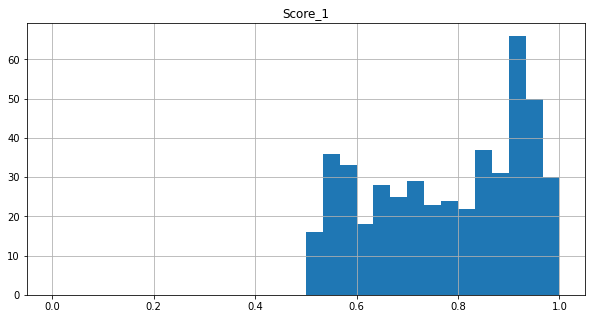

In [13]:
new_predictions[new_predictions["Label"]==1][["Score_1"]].hist(bins=30, figsize=(10,5), range=[0,1])

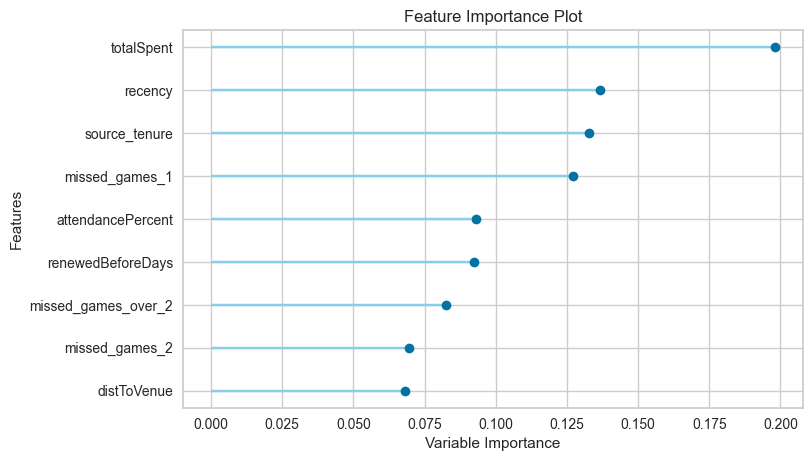

In [14]:
plot_model(best_model, plot='feature')

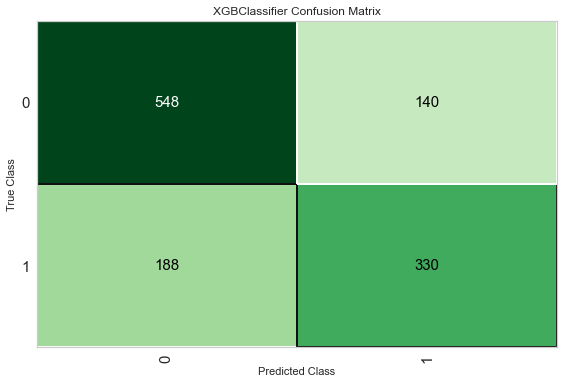

In [15]:
plot_model(best_model, plot='confusion_matrix')

## Observations
Here you can document some ideas on the results from above


## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?